In [ ]:
# Life Expectancy Analysis — Imports and Settings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option("display.max_columns", 200)
sns.set_context("talk")

In [ ]:
# Load dataset
df = pd.read_csv("Life Expectancy Data.csv")  # replace with your filename
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
df.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness__1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# Initial overview of dataset
print("Shape:", df.shape)
print(df.dtypes.value_counts())
df.describe(include="all").T

Shape: (2938, 22)
float64    16
int64       4
object      2
Name: count, dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,2938,193,Afghanistan,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2938.0,NaN,NaN,NaN,2007.51872,4.613841,2000.0,2004.0,2008.0,2012.0,2015.0
status,2938,2,Developing,2426,NaN,NaN,NaN,NaN,NaN,NaN,NaN
life_expectancy,2928.0,NaN,NaN,NaN,69.224932,9.523867,36.3,63.1,72.1,75.7,89.0
adult_mortality,2928.0,NaN,NaN,NaN,164.796448,124.292079,1.0,74.0,144.0,228.0,723.0
infant_deaths,2938.0,NaN,NaN,NaN,30.303948,117.926501,0.0,0.0,3.0,22.0,1800.0
alcohol,2744.0,NaN,NaN,NaN,4.602861,4.052413,0.01,0.8775,3.755,7.7025,17.87
percentage_expenditure,2938.0,NaN,NaN,NaN,738.251295,1987.914858,0.0,4.685343,64.912906,441.534144,19479.91161
hepatitis_b,2385.0,NaN,NaN,NaN,80.940461,25.070016,1.0,77.0,92.0,97.0,99.0
measles,2938.0,NaN,NaN,NaN,2419.59224,11467.272489,0.0,0.0,17.0,360.25,212183.0


In [ ]:
# Convert numeric columns
num_cols = ["year","life_expectancy","adult_mortality","infant_deaths","alcohol",
            "percentage_expenditure","hepatitis_b","measles","bmi","under-five_deaths",
            "polio","total_expenditure","diphtheria","hiv/aids","gdp","population",
            "thinness_1-19_years","thinness_5-9_years","income_composition_of_resources",
            "schooling"]

num_cols = [c for c in num_cols if c in df.columns]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

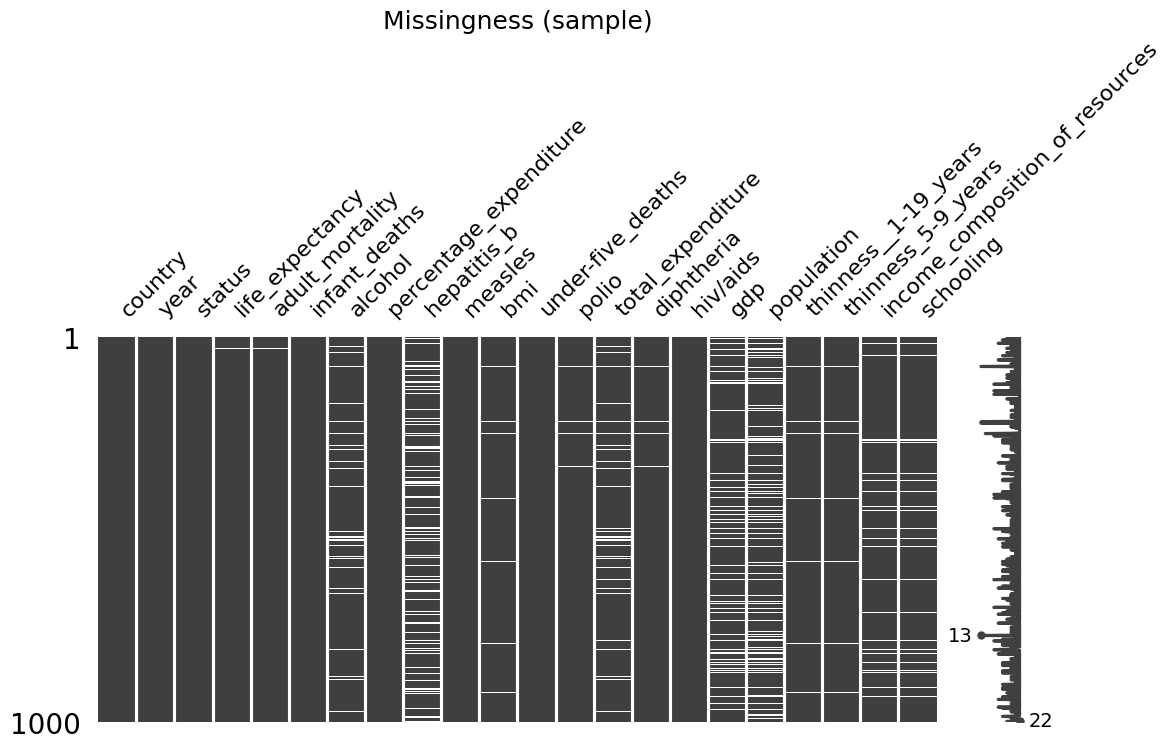

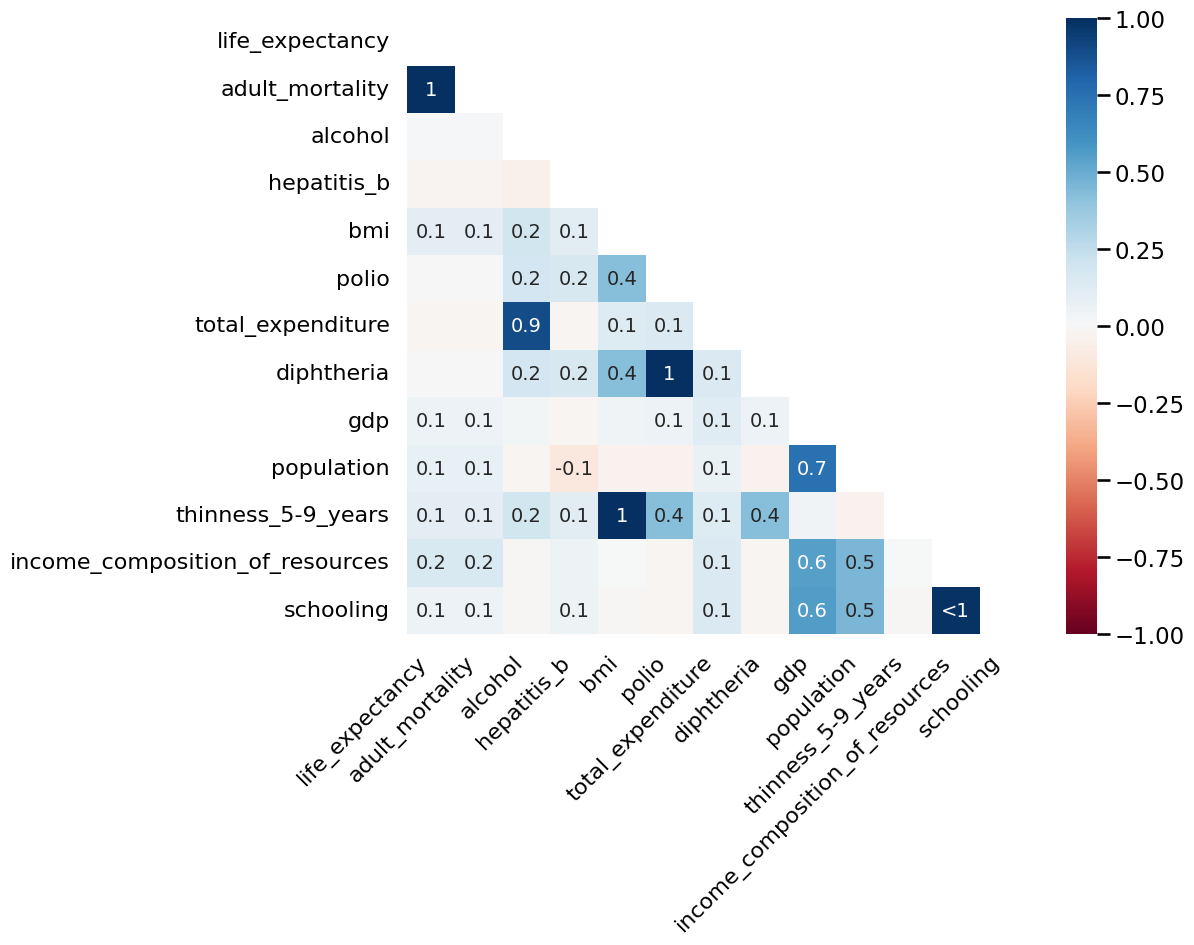

In [ ]:

# Visualize missing values
msno.matrix(df.sample(min(1000, len(df))), figsize=(12,5))
plt.title("Missingness (sample)")
plt.show()

msno.heatmap(df[num_cols], figsize=(10,8))
plt.show()

In [ ]:

# Drop countries with excessive missingness (>30%)
country_missing = df.groupby("country")[num_cols].apply(lambda x: x.isna().mean().mean())
bad_countries = country_missing[country_missing > 0.30].index.tolist()
print("Dropping countries:", len(bad_countries))
df = df[~df["country"].isin(bad_countries)].copy()

Dropping countries: 5


In [ ]:

# Feature engineering
if "gdp" in df.columns and "population" in df.columns:
    df["gdp_per_capita"] = df["gdp"] / df["population"].replace(0, np.nan)
df["year_centered"] = df["year"] - df["year"].median()

imm_cols = [c for c in ["hepatitis_b","polio","diphtheria"] if c in df.columns]
if imm_cols:
    df["immun_comp"] = df[imm_cols].mean(axis=1)

In [ ]:

# Impute missing data
def interp_country(g):
    return g.sort_values("year").interpolate(limit_direction="both")

df = df.groupby("country").apply(interp_country).reset_index(drop=True)

imputer_cols = [c for c in num_cols + ["gdp_per_capita","immun_comp"] if c in df.columns]
imputer = KNNImputer(n_neighbors=5)
df_imputed = df.copy()
df_imputed[imputer_cols] = imputer.fit_transform(df_imputed[imputer_cols])
df = df_imputed

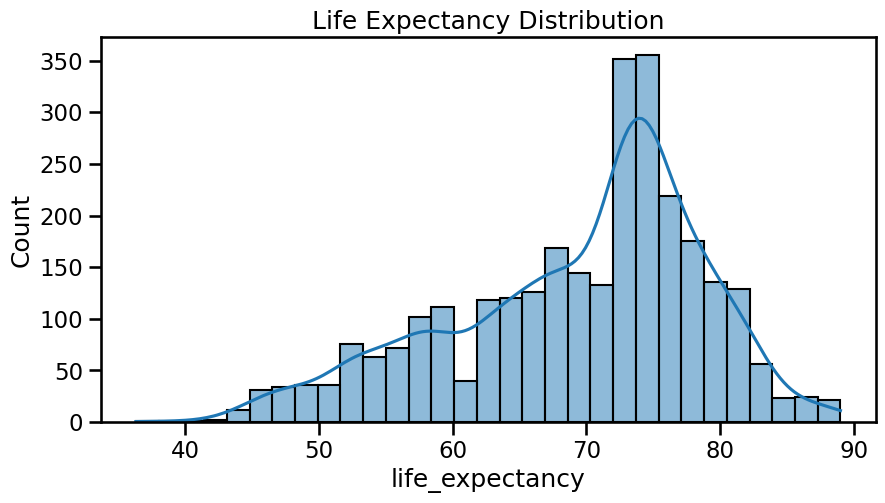

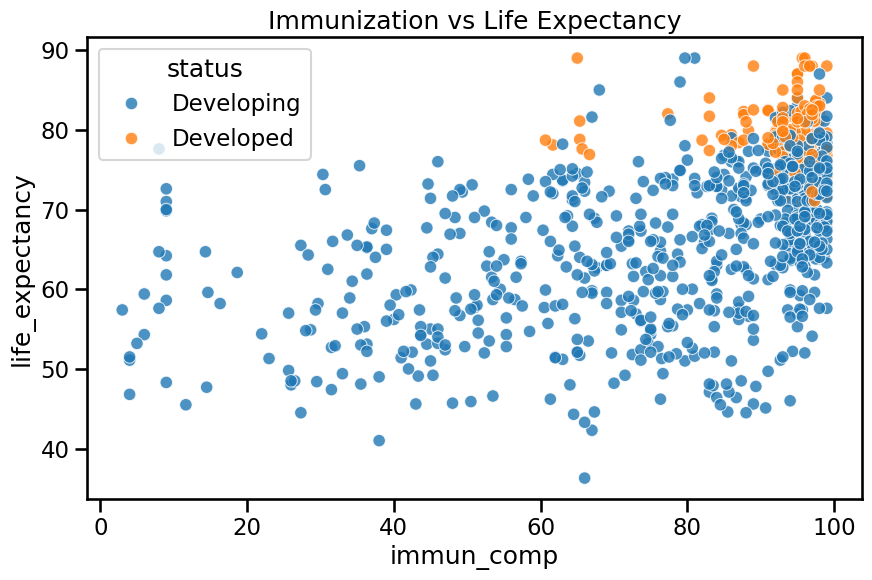

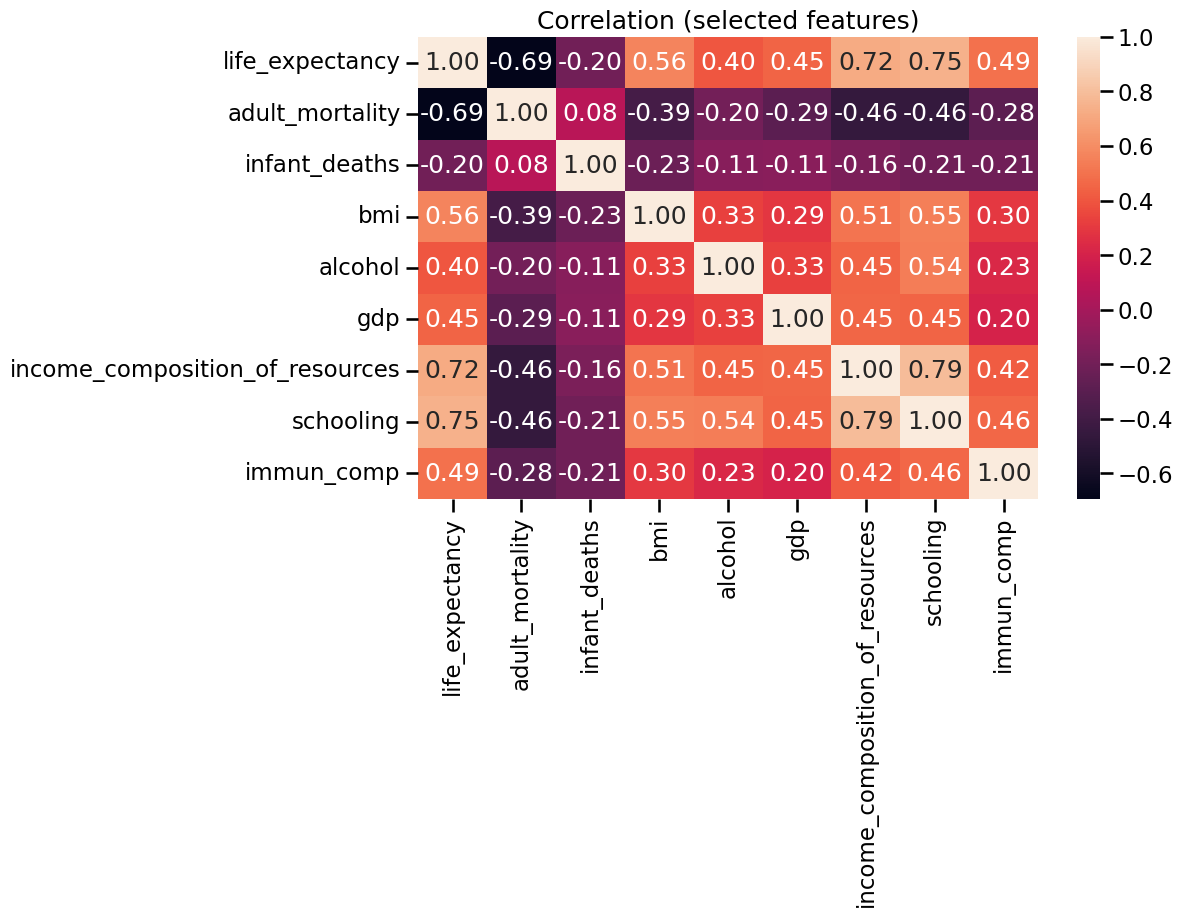

In [ ]:

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,5))
sns.histplot(df["life_expectancy"].dropna(), kde=True)
plt.title("Life Expectancy Distribution")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=df.sample(1000), x="immun_comp", y="life_expectancy", hue="status", alpha=0.8)
plt.title("Immunization vs Life Expectancy")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df[["life_expectancy","adult_mortality","infant_deaths","bmi","alcohol","gdp","income_composition_of_resources","schooling","immun_comp"]].corr(), annot=True, fmt=".2f")
plt.title("Correlation (selected features)")
plt.show()

In [ ]:

# Prepare dataset for modeling
model_cols = ["life_expectancy","year_centered","adult_mortality","infant_deaths","alcohol","bmi",
              "hiv/aids","gdp_per_capita","income_composition_of_resources","schooling","immun_comp","country","status"]

model_cols = [c for c in model_cols if c in df.columns]
mdl = df[model_cols].dropna().copy()

if "status" in mdl.columns:
    if mdl["status"].nunique() == 2:
        mdl["status_bin"] = (mdl["status"].astype(str).str.lower().str.contains("developed")).astype(int)
        mdl = mdl.drop(columns=["status"]).rename(columns={"status_bin":"status"})
    else:
        mdl = pd.get_dummies(mdl, columns=["status"], drop_first=True)

In [ ]:

# Group-aware train/test split
groups = mdl["country"]
gkf = GroupKFold(n_splits=5)
train_idx, test_idx = next(iter(gkf.split(mdl, mdl["life_expectancy"], groups)))
train = mdl.iloc[train_idx].copy()
test = mdl.iloc[test_idx].copy()

In [ ]:

# Standardize predictors
predictors = [c for c in train.columns if c not in ("life_expectancy","country")]
num_predictors = [c for c in predictors if train[c].dtype.kind in "fi"]

scaler = StandardScaler()
train[num_predictors] = scaler.fit_transform(train[num_predictors])
test[num_predictors] = scaler.transform(test[num_predictors])

In [ ]:

# Multiple Linear Regression
X_train = train[predictors]
y_train = train["life_expectancy"]
X_test = test[predictors]
y_test = test["life_expectancy"]

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("OLS RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("OLS R2:", r2_score(y_test, y_pred))

X_sm = sm.add_constant(pd.concat([train[predictors], test[predictors]]))
y_sm = pd.concat([y_train, y_test])
model_sm = sm.OLS(y_sm, X_sm).fit(cov_type="HC3")
print(model_sm.summary())

OLS RMSE: 3.932472438127498
OLS R2: 0.8045342713677637
                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     966.1
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        04:52:45   Log-Likelihood:                -8263.1
No. Observations:                2918   AIC:                         1.655e+04
Df Residuals:                    2906   BIC:                         1.662e+04
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------

In [ ]:

# Variance Inflation Factor (VIF)
X_vif = sm.add_constant(train[predictors])
vif_df = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})
vif_df.sort_values("VIF", ascending=False)

,feature,VIF
9,schooling,3.703672
8,income_composition_of_resources,3.138476
2,adult_mortality,1.791189
4,alcohol,1.723060
11,status,1.611732
5,bmi,1.582353
6,hiv/aids,1.423286
10,immun_comp,1.327803
1,year_centered,1.134349
3,infant_deaths,1.101243


In [ ]:

# Rename columns that contain special characters
df.rename(columns={'hiv/aids': 'hiv_aids'}, inplace=True)
if 'hiv/aids' in train.columns:
    train.rename(columns={'hiv/aids': 'hiv_aids'}, inplace=True)
if 'hiv/aids' in test.columns:
    test.rename(columns={'hiv/aids': 'hiv_aids'}, inplace=True)

In [ ]:

# Linear Mixed Effects Model (random intercept per country)
fixed_effects = [c for c in predictors if c not in ("country","hiv/aids")]
if "hiv_aids" in df.columns:
    fixed_effects.append("hiv_aids")
formula = "life_expectancy ~ " + " + ".join(fixed_effects)
print("Formula:", formula)

md = smf.mixedlm(formula, data=train.assign(life_expectancy=y_train), groups=train["country"])
mdf = md.fit(reml=False, method="lbfgs")
print(mdf.summary())

Formula: life_expectancy ~ year_centered + adult_mortality + infant_deaths + alcohol + bmi + gdp_per_capita + income_composition_of_resources + schooling + immun_comp + status + hiv_aids
                   Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     life_expectancy
No. Observations:       2326        Method:                 ML             
No. Groups:             151         Scale:                  3.4720         
Min. group size:        1           Log-Likelihood:         -5141.5726     
Max. group size:        16          Converged:              Yes            
Mean group size:        15.4                                               
---------------------------------------------------------------------------
                                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                       69.423    0.543 127.941 0.000 68.360 70.

In [ ]:

# Evaluate MixedLM model
exog_test = sm.add_constant(test[fixed_effects])
pred_mixed = mdf.predict(exog=exog_test)

print("MixedLM RMSE:", np.sqrt(mean_squared_error(y_test, pred_mixed)))
print("MixedLM R2:", r2_score(y_test, pred_mixed))

MixedLM RMSE: 6.014796685955318
MixedLM R2: 0.5427211115543484


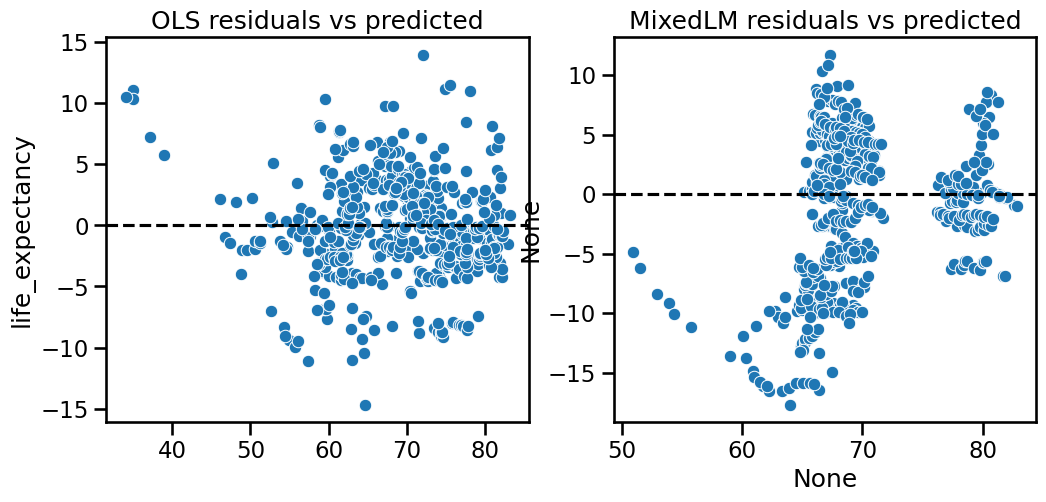

In [ ]:

# Residual diagnostics
res_ols = y_test - y_pred
res_mixed = y_test - pred_mixed

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.scatterplot(x=y_pred, y=res_ols)
plt.axhline(0, color="k", ls="--")
plt.title("OLS residuals vs predicted")

plt.subplot(1,2,2)
sns.scatterplot(x=pred_mixed, y=res_mixed)
plt.axhline(0, color="k", ls="--")
plt.title("MixedLM residuals vs predicted")

plt.show()

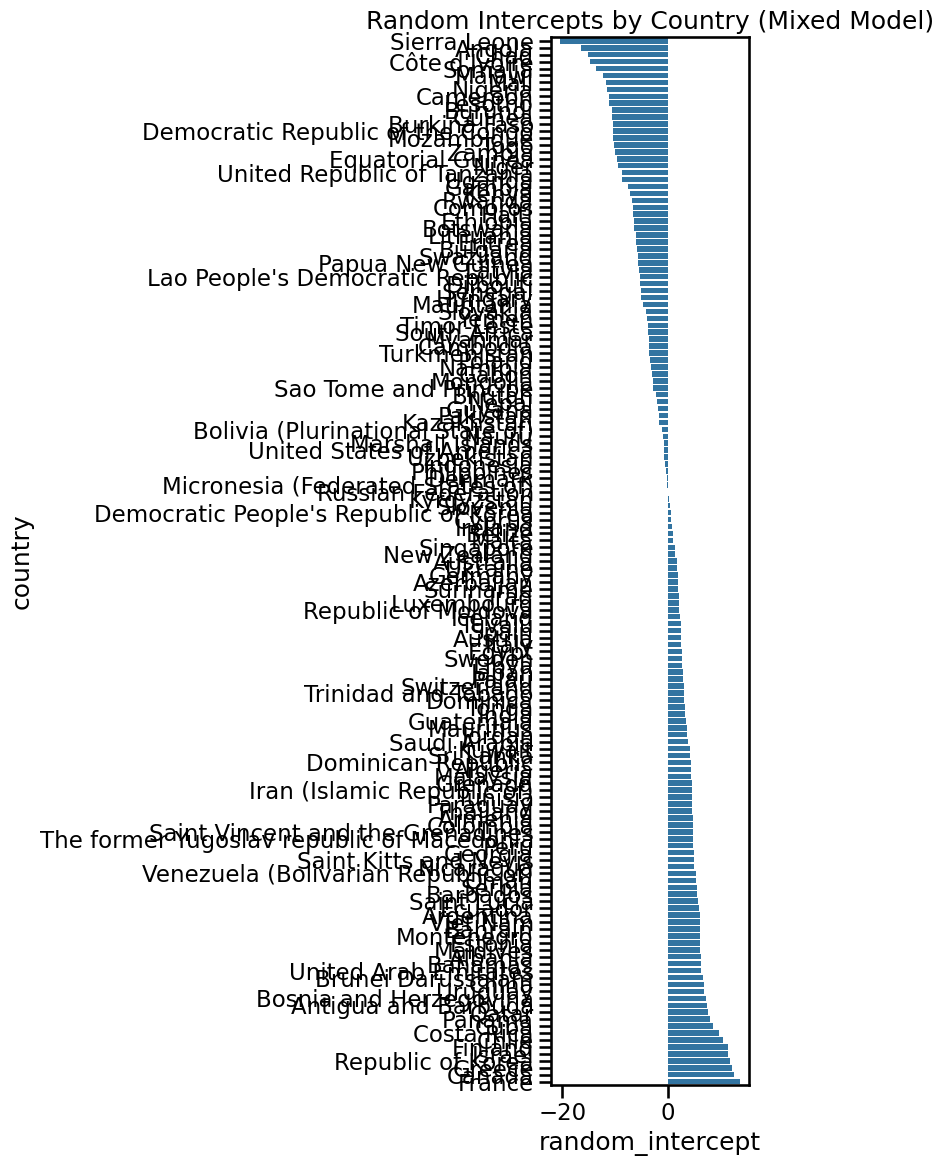

In [ ]:
# Cell 18 — Random intercepts by country (Safe extraction and plotting)
if "country" in train.columns:
    random_effects = {}
    for country_name, re_value in mdf.random_effects.items():
        # re_value can be dict, Series, or scalar
        if isinstance(re_value, dict):
            val = list(re_value.values())[0]
        elif isinstance(re_value, pd.Series):
            val = re_value.iloc[0]
        else:
            val = re_value
        random_effects[country_name] = val

    re_df = pd.DataFrame({
        "country": list(random_effects.keys()),
        "random_intercept": list(random_effects.values())
    }).sort_values("random_intercept")

    plt.figure(figsize=(8,12))
    sns.barplot(x="random_intercept", y="country", data=re_df)
    plt.title("Random Intercepts by Country (Mixed Model)")
    plt.tight_layout()
    plt.show()


In [ ]:

# Identify countries with low life expectancy
low_countries = df.groupby("country")["life_expectancy"].mean().nsmallest(10).index.tolist()
report = df[df["country"].isin(low_countries)].groupby("country").agg({
    "life_expectancy":"mean",
    "immun_comp":"mean",
    "adult_mortality":"mean",
    "infant_deaths":"mean",
    "gdp_per_capita":"mean",
    "schooling":"mean"
}).sort_values("life_expectancy")
report

,life_expectancy,immun_comp,adult_mortality,infant_deaths,gdp_per_capita,schooling
country,,,,,,
Sierra Leone,46.11250,72.010417,357.8125,27.5625,0.000572,8.23125
Central African Republic,48.51250,41.833333,333.0625,16.5000,0.002409,6.23750
Lesotho,48.78125,74.052083,550.0625,4.5000,0.006758,10.65625
Angola,49.01875,48.093750,328.5625,83.7500,0.001478,8.04375
Malawi,49.89375,86.218750,424.4375,37.1250,0.000210,10.23125
Chad,50.38750,29.447917,227.7500,44.8750,0.003309,6.08750
Côte d'Ivoire,50.38750,66.302083,417.3125,61.5000,0.002018,8.20250
Zimbabwe,50.48750,73.791667,462.3750,26.5625,0.000398,9.82500
Swaziland,51.32500,82.916667,339.0000,2.6250,0.060438,10.35000


In [ ]:

# Save cleaned data and models
df.to_csv("life_expectancy_cleaned.csv", index=False)
import joblib
joblib.dump(scaler, "scaler.pkl")
joblib.dump(lr, "linear_regression_model.pkl")
joblib.dump(mdf, "mixedlm_model.pkl")

print("Saved cleaned dataset and models successfully.")

Saved cleaned dataset and models successfully.


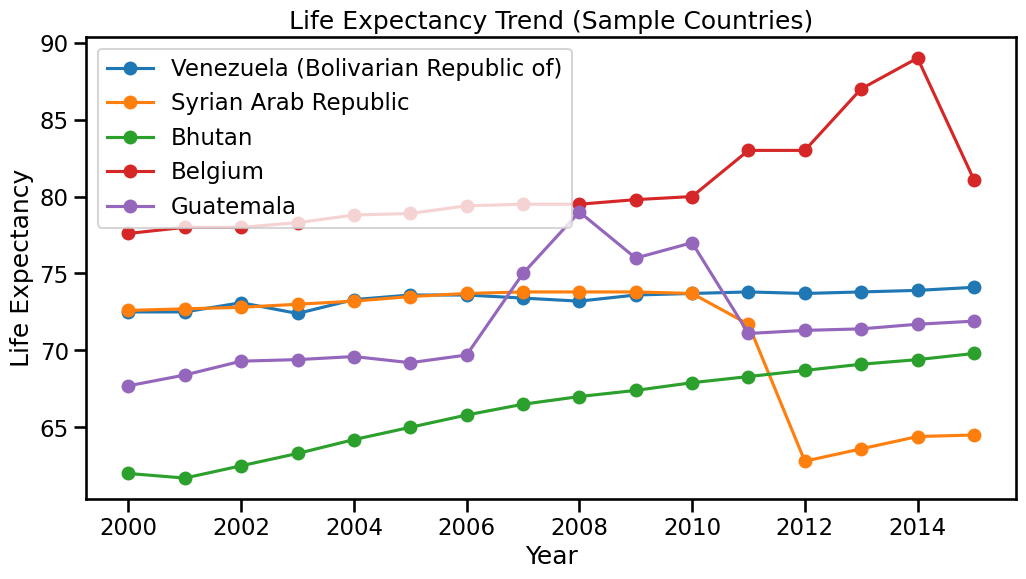

In [ ]:

# Trend of Life Expectancy over years for sample countries
sample_countries = df['country'].drop_duplicates().sample(5, random_state=42).tolist()
plt.figure(figsize=(12,6))
for country in sample_countries:
    sub = df[df['country'] == country]
    plt.plot(sub['year'], sub['life_expectancy'], marker='o', label=country)
plt.xlabel("Year")
plt.ylabel("Life Expectancy")
plt.title("Life Expectancy Trend (Sample Countries)")
plt.legend()
plt.show()

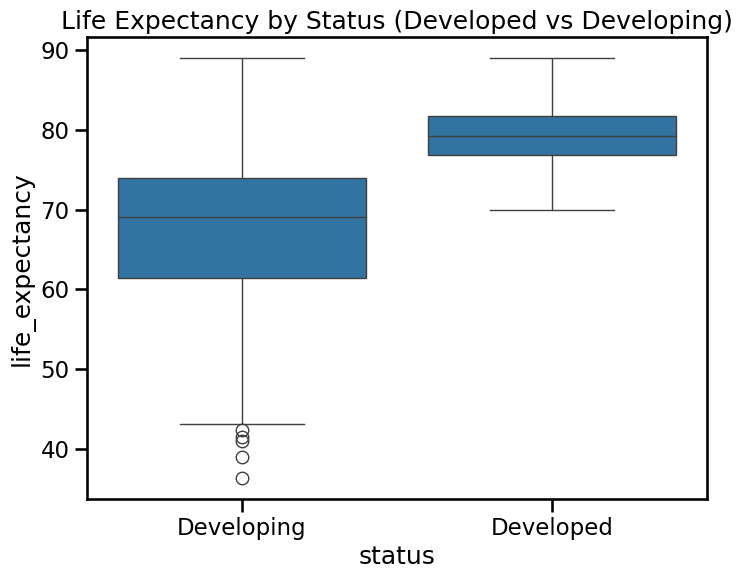

In [ ]:

# Boxplot: Life Expectancy by Status
if "status" in df.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, x="status", y="life_expectancy")
    plt.title("Life Expectancy by Status (Developed vs Developing)")
    plt.show()

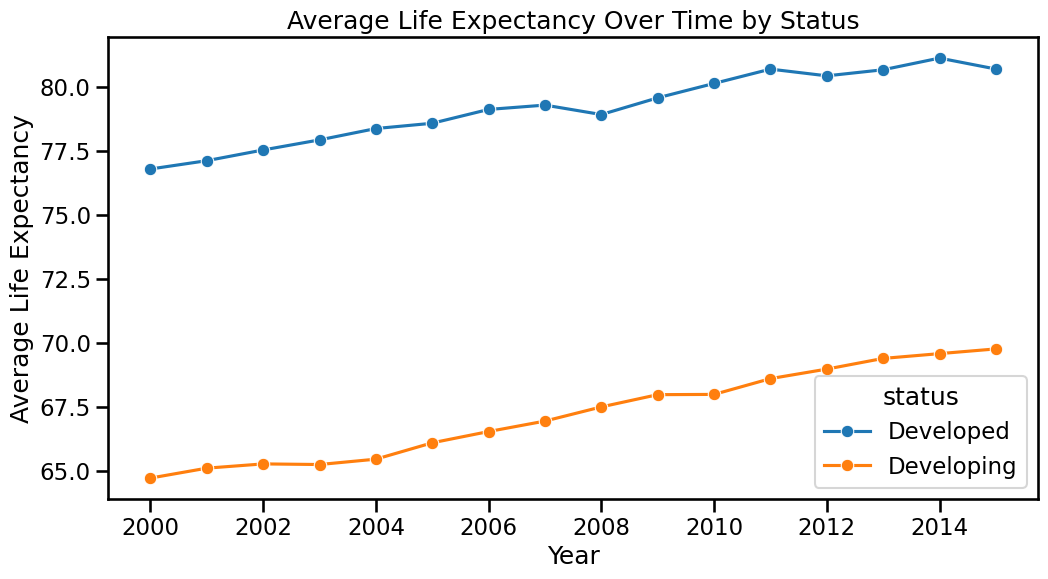

In [ ]:

# Line plot: Average life expectancy over time by Status
if "status" in df.columns:
    avg_life = df.groupby(['year','status'])['life_expectancy'].mean().reset_index()
    plt.figure(figsize=(12,6))
    sns.lineplot(data=avg_life, x='year', y='life_expectancy', hue='status', marker="o")
    plt.title("Average Life Expectancy Over Time by Status")
    plt.xlabel("Year")
    plt.ylabel("Average Life Expectancy")
    plt.show()